In [658]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

<b><h3>Regression and Prediction</h3></b>

Is the variable X (or more likey $X_1$,...,$X_p$) associated with a variable Y, and if so, what is the relationship and can we use it to predict Y ie the prediction of an outcome (target) variable based on the values of other "predictor" variables. This process of training a model on data where the outcome is known, for subsequent application to data where the outcome is not known, is termed supervised learning. In anomaly detection, the regression diagnostics originally intended for data analysis and improving the regression model can be used to detect unusual records.

<b><h3>Simple Linear Regression</h3></b>

Simple linear regression provides a model of the relationship between the magnitude of one variable and that of a second - for example, as X increases, Y also increases. Or as X increases, Y decreases. Correlation is another way to measure how two variables are related. The difference is that while correlation measures the strength of an association between two variables, regression quantifies the nature of the relationship.

<b><h4>The Regression Equation</h4></b>

Simple linear regression estimates how much Y will change when X changes by a certain amount. With the correlation coefficient, the variables X and Y are interchangeable. With regression, we are trying to predict the variable Y from X using a linear relationship (ie, a line):

$Y$ = $b_0$ + $b_1X$

The scikit-learn LinearRegression() model can be instantiated and fitted to data using the predict() method. The fitted model to learn the intercept (intercept_ attribute ) and coefficients (coefficient_ attribute) . Predictions are made by passing a 2D numpy ndarray to the predict() method (we can just pass a data frame and the underlying 2D nd array will be used.)

In [659]:
# Number of years a worker has been exposed to cotton dust (Exposure) versus a measure of lung capacity  PEFR
# (peak expiratory flow rate)
import pandas as pd
lung = pd.read_csv('../data/LungDisease.csv')
lung.head()

,PEFR,Exposure
0,390,0
1,410,0
2,430,0
3,460,0
4,420,1


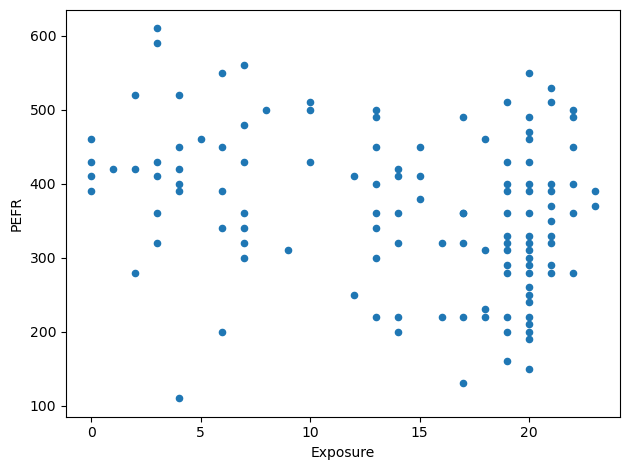

In [660]:
ax = lung.plot.scatter(x='Exposure', y='PEFR')
ax.set_xlabel('Exposure')
ax.set_ylabel('PEFR')
plt.tight_layout()

In [661]:
predictors = ['Exposure']
outcome = 'PEFR'

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])
print(f"Intercept: {model.intercept_ : .3f}")
print(f"Coefficient Exposure: {model.coef_[0] : .3f}")

Intercept:  424.583
Coefficient Exposure: -4.185


In [662]:
model.coef_

array([-4.18457649])

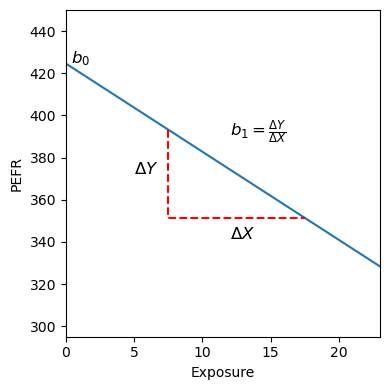

In [663]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot((0,23), model.predict(np.array([[0],[23]])))
ax.set_xlabel('Exposure')
ax.set_ylabel('PEFR')
ax.set_xlim(0,23)
ax.set_ylim(295,450)
ax.text(0.4, model.intercept_, s=r'$b_0$', size='larger')

# drawing the intercept line
x = pd.DataFrame({'Exposure':[7.5, 17.5]})
y = model.predict(x)
ax.plot((7.5,7.5,17.5), (y[0], y[1], y[1]), 'r--') # inner point share same x as first point, same y as second pint
ax.text(5,np.mean(y), s=r'$\Delta Y$', size='larger') # LaTEX
ax.text(12,y[1]-10, s=r'$\Delta X$', size='larger')
ax.text(12, 390, s=r'$b_1=\frac{\Delta Y}{\Delta X}$', size='larger')

plt.tight_layout()

<b><h4>Fitted Models</h4></b>

Important concepts in regression analysis are the fitted values (the predictions) and residuals (prediction errors). In general, the data doesnt fall exactly on a line, so the regression equation should include an explicit error term $e_r$:

$Y_i$ = $b_0\;+\;b_1X_i\;+\,e_i$

The fitted values, also referred to as the predicted values, are typically denoted by $\hat Y_i$. These are given by:

$\hat Y_i$ = $\hat b_0\;+\;\hat b_1X_i$

The notation $\hat b_0$ and $\hat b_1$ indicates that the coefficients are estimated versus known. The "hat" notation is used to differentiate between estimates and known values. So the symbol $\hat b$ ("b-hat") is an estimate of the unknown parameter $b$. Statisticians differentiate between the estimate and the true values because the estimate has uncertainty whereas the true value is fixed.

We compute the residuals $\hat e_i$ by subtracting the predicted values from the original data:

$\hat e_i$ = $Y_i$ - $\hat Y_i$

With scikit-learn's LinearRegression() model, we use the predict() method on the training data to get the fitted values and subsequently the residuals.

In [664]:
fitted = model.predict(lung[predictors])
residuals = lung[outcome] - fitted

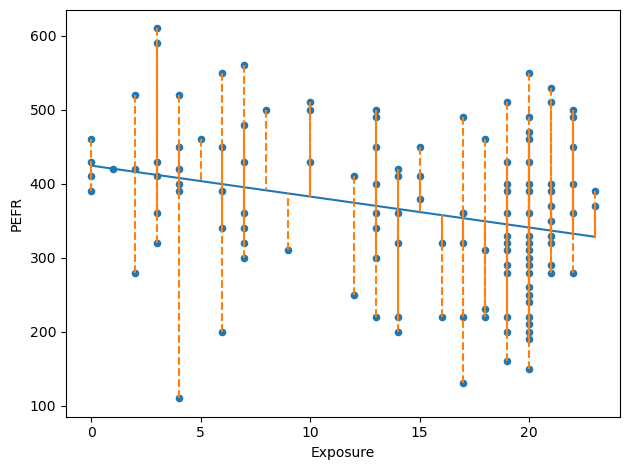

In [665]:
ax = lung.plot.scatter('Exposure', 'PEFR')
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted):
    ax.plot((x,x), (yactual, yfitted), '--', color='C1')
plt.tight_layout()

<b><h4>Least Squares</h4></b>

How is the model fit to the data? When there is a clear relationship, you could imagine fitting a line by hand. In practice, the regression line is the estimate that minimizes the sum of squared residual values, also called the residual sum of squares or RSS:

$RSS$ = $\sum_{i=i}^n(Y_i - \hat Y_i)^2$  = $\sum_{i=1}^n(Y_i - \hat b_0 - \hat b_1X_i)^2$

The estimates $\hat b_0$ and $\hat b_1$ are the values that minimizes RSS.

The method of minimizing the sum of the squared residuals is termed least squares regression or ordinary least squares (OLS) regression. Least squares, like the mean, are sensitive to outliers, although this tends to be a significant problem only in small or moderate-sized data sets.

<b><h4>Prediction Versus Explanation (Profiling)</h4></b>

Historically, a primary use of regression was to illuminate a supposed linear relationship between predictor variables and an outcome variable. The goal has been to understand a relationship and explain it using the data that the regression was fit to. In this case, the primary focus is on the estimated slope of the regression equation, $\hat b$. Economists want to know the relationship between consumer spending and GDP growth. Public health officials want to understand whether a public information campaig is effective in promoting safe sex practices. In such cases, the focus is not on promoting individual cases but rather on understanding the overall relationship among variables.

With the advent of big data, regression is widely used to form a model to predict individual outcomes for new data (ie a predictive model) rather than explain data in hand. In this instance, the main items of interest are the fitted values $\bar Y$. In marketing, regression can be used to predict the change in revenue in response to the size of an ad campaign. Universities use regression to predict student's GPA based on their SAT scores.

A regression model that fits the data well is set up such that the changes in X lead to changes in Y. However, by itself, the regression equation does not prove the direction of causation. Conclusions about causation must come from a broader understanding about the relationship. For example, a regression equation might show a definite relationship between the number of clicks on a web ad and number of conversions. It is our knowledge of the marketing process, not the regression equation, that leads us to the conclusion that clicks on the ad lead to sales,and not vice versa.

<b><h3>Multiple Linear Regression</h3></b>

When there are multiple predictors, the equation is simply extended to accomodate them:

$Y$ = $b_0\;+\;b_1X_1\;+\;b_2X_2\;+\;...\;+\;b_pX_p\;+\;e$

Instead of a line, we now have a linear model - the relationship between each coefficient and its variable (feature) is linear. All of the other concepts in simple linear regression, such as fitting by least squares and the definition of fitted values and residuals, extend to the multiple linear regression setting. For example, the fitted values are given by:

$\hat Y$ = $\hat b_0\;+\;\hat b_1X_{1,i}\;+\;\hat b_2X_{2,i}\;+\;...\;+\;\hat b_pX_{p,i}$

In Python, scikit-learn's LinearRegression() model can be used for multiple linear regression as well.

<b><h4>Example : King County Housing Data</h4></b>

An example of using multiple linear regression is in estimating the value of houses. County assessors must estimate the value of a house for the purposes of assessing taxes. Real estate professionals and home buyers consult popular websites like Zillow to ascertain a fair price. Data from the prices for which houses were sold can be used for this.

In [666]:
house = pd.read_csv('../data/house_sales.csv', sep='\t')
house.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,Bathrooms,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction
1,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,...,3.00,6,7,1991,0,0,70000,229000,98002,False
2,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,...,3.75,4,10,2005,0,0,203000,590000,98166,True
3,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,...,1.75,4,8,1947,0,0,183000,275000,98166,False
4,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,...,3.75,5,7,1966,0,0,104000,229000,98168,False
5,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,...,1.75,4,7,1948,0,0,104000,205000,98168,False


In [667]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'   

house[[outcome,*predictors ]].head()

,AdjSalePrice,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade
1,300805.0,2400,9373,3.00,6,7
2,1076162.0,3764,20156,3.75,4,10
3,761805.0,2060,26036,1.75,4,8
4,442065.0,3200,8618,3.75,5,7
5,297065.0,1720,8620,1.75,4,7


In [668]:
house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

LinearRegression()

In [669]:
print(f"Intercept: {house_lm.intercept_:.3f}\n")
coefs = pd.DataFrame({'Coefficients':house_lm.coef_}, index=predictors)
coefs

Intercept: -521871.368



,Coefficients
SqFtTotLiving,228.830604
SqFtLot,-0.060467
Bathrooms,-19442.840398
Bedrooms,-47769.955185
BldgGrade,106106.963079


The interpretation of the coefficients is as with simple linear regression: the predicted value $\bar Y$ changes by the coefficient $b_j$ for each unit change in $X_j$ assuming all the other variables, X_k for k $\neq$ j, remain the same. For example, adding an extra finished square foot to a house increases increases the estimated value by roughly $229 with all other variables remaning the same.

<b><h4>Assessing the Model</h4></b>

The most important performane metric from a data science perspective is root mean squared error or RMSE. RMSE is the square root of the average squared error in the predicted $\hat y_i$ values:

$RMSE$ = $\sqrt{\frac{\sum_{i=1}^n(y_i - \hat y_i)^2}{n}}$

This measures the overall accuracy of the model and is a basis for comparing it to other models (including models fit using machine learning techniques). 

Similar to RMSE is the residual standard error, or RSE. In this case we have p predictors, and the RSE is given by:

$RSE$ = $\sqrt {\frac{\sum_{i=1}^n(y_i - \hat  y_i)}{(n-p-1)}}$

The only difference is that the denominator is the degrees of fredom, as opposed to the number of records. In practice, for linear regression, the difference between RMSE and RSE is very small, particularly for big data applications.

scikit-learn provides a number of metrics for regression and classification. Here, we use mean_squared error to get RMSE and r2_score for the coefficent of determination.

In [670]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f"RMSE: {RMSE :.0f}")
print(f"r2 : {r2:.4f}")

RMSE: 261220
r2 : 0.5406


statsmodels provides a more detailed analysis of the regression model in Python. As statsmodels doesn't add an intercept automatically, we need to add a constant column with value 1 to the predictors. We use the pandas assign() method for this. This method is used to assign new columns to a DataFrame, returning a new object with all original columns in addition to new ones.

In [671]:
model = sm.OLS(house[outcome], house[predictors].assign(const=1)) # note endogenous(endog) = y, exogenous(exog) = x
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Tue, 19 Sep 2023   Prob (F-statistic):               0.00
Time:                        11:47:05   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.8306      3.899     58.694      0.000     221.189     236.472
SqFtLot          -0.0605      0.061     -0.988      0.323      -0.180       0.059
Bathrooms     -1.944e+04   3625.388     -5.363      0.000   -2.65e+04   -1.23e+04
Bedrooms      -4.777e+04   2489.732    -19.187      0.000   -5.27e+04   -4.29e+04
BldgGrade      1.061e+05   2396.445     44.277      0.000    1.01e+05    1.11e+05
const         -5.219e+05   1.57e+04    -33.342      0.000   -5.53e+05   -4.91e+05
==============================================================================
Omnibus:                    29676.557   Durbin-Watson:                   1.247
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19390738.346
Skew:                           6.889   Prob(JB):                         0.00
Kurtosis:                     145.559   Cond. No.                     2.86e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Another useful metricis the coefficient of determination, also called the R-squared statistic or $R^2$.<b> R-squared ranges from 0 to 1 and measures the proportion of variation in the data that is accounted for in the model</b>. It is useful mainly in explanatary uses of regression where you want to assess how well the model fits the data. The formula for $R^2$ is:

$R^2$ = 1 - $\frac{\sum_{i=1}^n(y_i - \bar y_i)^2}{\sum_{i=1}^n(y_i - \bar y)^2}$

The denominator is proportional to the variance of $Y$ given that it is the squared deviation. The numerator is the squared error. The output from statsmodels also reports an adjusted R-squared, which adjusts for the degrees of freedom, effectively penalizing the addition of more predictors to a model. Seldom is this significantly different from R-squared in multiple regression with large data sets.

Along with the estimated coefficients, statsmodels report the standard error of the coefficients (SE) and a t-statistic:

$t_b$ = $\frac{\hat b}{SE(\hat b)}$

The t-statistic  - and its mirror image, the p-value - measures the extent to which a coefficient is "statistically significant" - that is, outside the range of what a random chance arrangement of predictor and target variable might produce. The higher the t-statistic (and the lower the p-value), the more significant the predictor. Sine parsimony is a valuable model feature, it is useful to have a tool like this to guide choice of variables to include as predictors.

<b><h4>Cross-Validation</h4></b>

Classic statistical regression metrics ($R^2$, F-statistics, and p-values) are all "in-sample" metrics - they are applied to the same data that was used to fit the model. Intuitively, you can see that it would make a lot of sense to set aside some of the original data, not use it to fit the model, and then apply the model to the set-aside (holdout) data to see how well it does. Normally, you would use a majority of the data to fit the model and use a smaller portion to test the model.

This idea of "out-of-sample" validation is not new, but it did not really take hold until larger data sets became more prevalent; with a small data set, analysts typically want to use all the data and fit the best possible model.

Using a holdout sample, though, leaves you subject to some uncertainty that arises simply from variability in the small holdout sample. How different would the assessment be if you selected a different holdout sample?

Cross-validation extends the idea of a holdout sample to multiple sequential holdout samples. The algorithm for basic k-fold cross-validation is as follows:
1. Set aside 1/k of the data as a holdout sample.
2. Train the model on the remaining data.
3. Apply (score) the model to the 1/k holdout, and record needed model assessment metrics.
4. Restore the first 1/k of the data, and set aside the next 1/k (excluding any records that got picked the first time).
5. Repeat steps 2 and 3.
6. Repeat until each record has been used in the holdout portion.
7. Average or otherwise combine the model assessment metrics.

The division of the data into the training sample and the holdout smaple is also called a fold.

<b><h4>Model Selection and Stepwise Regression</h4></b>

In some problems, many variables could be used as predictors in a regression. For example, to predict house value, additional variables such as the basement size or year built could be used.  In Python, we need to convert the categorical and boolean variables into numbers using pandas.get_dummies() ie one-hot encoding , we set drop_first=True to avoid multicollinearity. This function will detect all the categorical columns and convert them to appropriate dummies. In the example below PropertyType is originally categorical and is converted to PropertyType_Single Family and PropertyType_Townhouse dummy variables, dropping PropertyType_Multiplex, the first unique PropertyType value. pandas.get_dummies() doesnt convert boolean columns so we have to manually convert those, for example the NewConstruction column below.

In [672]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True)
X.shape

(22687, 12)

In [673]:
X.columns

Index(['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade',
       'NbrLivingUnits', 'SqFtFinBasement', 'YrBuilt', 'YrRenovated',
       'NewConstruction', 'PropertyType_Single Family',
       'PropertyType_Townhouse'],
      dtype='object')

In [674]:
house.PropertyType.unique()

array(['Multiplex', 'Single Family', 'Townhouse'], dtype=object)

In [675]:
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

In [676]:
house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2771.
Date:                Tue, 19 Sep 2023   Prob (F-statistic):               0.00
Time:                        11:47:05   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:                         6.275e+05
Df Residuals:                   22674   BIC:                         6.276e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving                198.6364      4.234     46.920      0.000     190.338     206.934
SqFtLot                        0.0771      0.058      1.330      0.184      -0.037       0.191
Bathrooms                   4.286e+04   3808.114     11.255      0.000    3.54e+04    5.03e+04
Bedrooms                   -5.187e+04   2396.904    -21.638      0.000   -5.66e+04   -4.72e+04
BldgGrade                   1.373e+05   2441.242     56.228      0.000    1.32e+05    1.42e+05
NbrLivingUnits              5723.8438   1.76e+04      0.326      0.744   -2.87e+04    4.01e+04
SqFtFinBasement                7.0611      4.627      1.526      0.127      -2.009      16.131
YrBuilt                    -3574.2210     77.228    -46.282      0.000   -3725.593   -3422.849
YrRenovated                   -2.5311      3.924     -0.645      0.519     -10.222       5.160
NewConstruction            -2489.1122   5936.692     -0.419      0.675   -1.41e+04    9147.211
PropertyType_Single Family  2.997e+04   2.61e+04      1.149      0.251   -2.12e+04    8.11e+04
PropertyType_Townhouse      9.286e+04    2.7e+04      3.438      0.001    3.99e+04    1.46e+05
const                       6.182e+06   1.55e+05     39.902      0.000    5.88e+06    6.49e+06
==============================================================================
Omnibus:                    31006.128   Durbin-Watson:                   1.393
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         26251977.078
Skew:                           7.427   Prob(JB):                         0.00
Kurtosis:                     168.984   Cond. No.                     2.98e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Adding more variables, however, does not necessarily mean we have a better model. Statisticians use the principle of Occam's razor to guide the choice of a model: all things being equal a simpler model should be used in preference to a more complicated model. Including additional variables always reduces RMSE and increases $R^2$ for the training data. Hence, these are not appropriate to help guide the model choice. One approach to including model complexity is to use the adjusted $R^2$:

$R^2_{adj} \;=\; 1 \;-\; (1 \;-\; R^2)\frac{n-1}{n-P-1}$

where n is the number of recores and P is the number of variables in the model.

Akaike's Information Criteria (AIC) is a metric that penalizes adding terms to a model. In the case of regression, AIC has the form:

$AIC\;=\;2P\;+\;nlog(RSS/n)$

where P is the number of variables and n is the number of records. The goal is to find the model that minimizes AIC; models with k more extra variables are penalized by 2k.

How do we find the model that minimizes $AIC$ or maximizes adjusted $R^2$? One way is to search through all possible models, an approach call <em>all subset regression</em>. This is computationally expensive and is not feasible for problems with large data and many variables. An attractive alternative is to use <em>stepwise regression</em>. It could start with a full model and successively drop variables that don't contribute meaningfully. This is called <em>backward elimination</em>. Alternatively oone could start with a constant model and successively add variables (<em>forward selection</em>). As a third option we can also successively add and drop predictors to find a model that lowers AIC or adjusted %R^2$. The python package $dmba$ can be used for implementing stepwise regression with AIC as follows:
1. Define a function that returns a fitted model for a given set of variables. 
2. Define a function that returns a fitted model for a given set of variables. In this case, we use the AIC_score implemented in the dmba package.

For the example below, the function chose a model in which several variables were dropped house_full: SqFtLot, NbrLivingUnits, YrRenovated, and NewConstruction.

In [677]:
y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y,[y.mean()]*len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, verbose=True)

print(f"Intercept: {best_model.intercept_:3f}")
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f"  {name}:  {coef}")

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=647988.32, constant
Step: score=633013.35, add SqFtTotLiving
Step: score=630793.74, add BldgGrade
Step: score=628230.29, add YrBuilt


Step: score=627784.16, add Bedrooms
Step: score=627602.21, add Bathrooms
Step: score=627525.65, add PropertyType_Townhouse
Step: score=627525.08, add SqFtFinBasement
Step: score=627524.98, add PropertyType_Single Family
Step: score=627524.98, unchanged None
Intercept: 6178645.017033
Coefficients:
  SqFtTotLiving:  199.27755304201781
  BldgGrade:  137159.56022619802
  YrBuilt:  -3565.424939249281
  Bedrooms:  -51947.38367361341
  Bathrooms:  42396.16452771811
  PropertyType_Townhouse:  84479.16203300335
  SqFtFinBasement:  7.046974967583083
  PropertyType_Single Family:  22912.055187017646


Simpler yet are <em>forward selection</em> and backward selection. In forward selection, you start with no predictors and add them one by one, at each step adding the predictor aht has the largest contribution to $R^2$ and stopping when the contribution is no longer statistically significant. In backward selection, or backward elimination, you start with a full model and take away predictors that are not statistically significant unitl you are left with a model in which all predictors are statistically significant.

Penalized regression is similar in spirit to AIC. Instead of explicitly searching through a discrete set of models, the model-fitting equation incorporates a constraint that penalizes the model for too many variables (parameters). Rather than eliminating predictor variables entirely - as with stepwise, forward and backward selection - penalized regression applies the penalty by reducing coefficients, in some cases to near zero. Common penalized regression methods are <em>ridge regression and lasso regression</em>.

Stepwise regression and all subset regression are <em>in-sample</em> methods to assess and tune models. This means the model selection is possibly subject to overfitting (fitting the noise in the data) and may not perform as well when applied to new data. One common approach to avoid this is to use cross-validation to validate the models. In linear regression, overfitting is typically not a major issue, due t the simple (linear) global structure imposed on the data. For more sophisticated types of models, particularly iterative procedures that respond to local data structure, cross-validation is a very important tool.

<b><h4>Weighted Regression</h4></b>

Weighted regression is used by statisticians for a variety of purposes; in particular, it is important for analysis of complex surveys. Data scientists may find weighted regression useful in two cases:
- Inverse-variance weightting when different observations have been measured with different precision; the higher variance one receiving lower weights.
- Analysis of data where rows represents multiple cases; the weight variable encodes how many original observations each row represents.

For example, with the housing data, older sales are less reliable than more recent sales. Using the DocumentDate to determine the year of the sale, we can compute a Weight as the number of years since 2005 (the beginning of the data). Most models in scikit-learn accept weights as the keyword argument sample_weight in th call of the fit() method.

In [678]:
house['Year'] = pd.to_datetime(house['DocumentDate']).dt.year

In [679]:
house['Weight'] = house.Year - 2005

In [680]:
predictors = ['SqFtTotLiving','SqFtLot','Bathrooms','Bedrooms','BldgGrade']

In [681]:
house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)

LinearRegression()

In [682]:
pd.concat([
pd.DataFrame({
        'predictor':predictors,
        'house_lm':house_lm.coef_, 
        'house_wt': house_wt.coef_}),
pd.DataFrame({
    'predictor' : ['intercept'],
    'house_lm' : house_lm.intercept_,
    'house_wt' : house_wt.intercept_
})])
        

,predictor,house_lm,house_wt
0,SqFtTotLiving,228.830604,245.024089
1,SqFtLot,-0.060467,-0.292415
2,Bathrooms,-19442.840398,-26085.970109
3,Bedrooms,-47769.955185,-53608.876436
4,BldgGrade,106106.963079,115242.434726
0,intercept,-521871.368188,-584189.329446


The intercept and coefficients in the weighted regression are slightly different from the original regression.

<b><h3>Prediction Using Regression</h3></b>

The primary purpose of regression in data science is prediction. This is useful to keep in mind, since regression, being an old and established statistical method, comes wih baggage that is more relevant to its traditional role as a tool for explanatory modeling than to prediction.

<b><h4>The Dangers of Exrapolation</h4></b>

Regression models should not be used to extrapolate beyond the range of the data (leaving aside the use of regression for time series forecasting). The model is valid only for predictor values for which the data has sufficient values. As an extreme case, suppose model_lm is used to predict the value of a 5,000 square-foot empty lot. In such a case, all the predictors related to the building would have a value of 0, and the regression equation would yield an absurd prediction of -521,900 + 5,000*-0.0605 = $-522,202. Why did this happen? The data contains only parcels with buildings= there are no records corresponding to a vacant land. Consequently, the model has no information to tell it how to predict the sales price of vacant land.

<b><h4>Confidence and Prediction Intervals</h4></b>

Much of statistics involves understanding and measuring variablity (uncertainty). The t-statistics and p-values reported in regression output deal wit this in a formal way, which is sometimes useful for variable selection. More useful metrics are confidence intervals, which are uncertainty intervals placed around regression coefficients and predictions. An easy way to understand this is via the bootstrap. The most common regression intervals are those for regression parameters (coefficients). Here is a bootstrap algorithm for generating confidence intervals for regression parameters (coefficients) for a data set with P predictors and n records (rows):
1. Consider each rows (including outcome variable) as a single "ticket" and place all the n tickets in a box.
2. Draw a ticket at random, record the values, and replace it in the box.
3. Repeat step 2 n times; you now have one bootstrap resample.
4. Fit a regression to the bootstrap sample, and record the estimated coefficients.
5. Repeat steps 2 through 4, say, 1,000 times.
6. You now have 1,000 bootstrap values for each coefficient; find the appropriate percentiles for each (eg 5th and 95th for a 90% confidence interval).

The conceptual meaning and interpretation are the same, and not of central importance to data scientists, because they concertn the regression coefficients. Of greater interest to data scientists are intervals around predicted y values ($\bar Y_i$). The uncertainty around $\bar Y_i$ comes from two sources:
- Uncertainty about what the relevant predictor variables and their coefficients are
- Additional eror inherent in individual data points

The individual data point error can be thought of as follows: even if we knew for certain what the regression equation was (eg if we had a huge number of records to fit it), the actual outcome values for a given set of predictor values will vary. For example, several houses - each with 8 rooms, a 6,500-square-foot lot, 3 bathrooms, and a basement - might have different sale prices. We can model this individual error with the residuals from the fitted values. The bootstrap algorithm for modeling both the regression model error and the individual data point error would look as follows:
1. Take a bootstrap sample from the data.
2. Fit the regression, and predict the new value.
3. Take a single residual at random from the original regression fit, add it to the predicted value, and record the result.
4. Repeat stesp 1 through 3, say 1,000 times.
5. Find the 2.5th and 97.5th percentiles of the results.

<b><h4>Prediction Interval or Confidence Interval</h4></b>

A prediction interval pertains to uncertainty around a single value, while a confidence interval pertains to a mean or other statistic calculated from multiple values. Thus a prediction interval will typically be much wider than a confidence interval for the same value. We model this individual value error in the bootstrap model by selecting an individual residual to tack on to the predicted value. Since data scientists are interested in specific individual predictions, a prediction interval would be more appropriate. Using a confidence interval when you should be using a prediction interval will greatly underestimate the uncertainty in a given predicted value.

<b><h3>Factor Variables in Regression</h3></b>

Factor variables, also termed categorical variables, take on a limited number of discrete values. For example, a loan purpose, can be "debt consolidation", "wedding", "car", and so on. The binary yes/no variable, also called an <em>indicator</em> variable, is a special case of a factor variable. Regression requires numerical inputs, so factor variables need to be recoded to use in the model. The most common approach is to convert a variable into a set of binary dummy variables.

<b><h4>Dummy Variables Representation</h4></b>

In the King County housing data, there is a factor varaible for the property type. There are three possible values: Multiplex, Single Family, and Townhouse. To use this factor variable, we need to convert it to a set of binary variables. We do this by creating a binary variable for each possible value of the factor variable. 

In certain machine learning algorithms, such as nearest neighbors and tree models, one hot encoding is the standard way to represent factor variables. In the regression setting, a factor variable with P distinct levels is usually represented by a matrix with only P - 1 columns. This is because a regression model typically includes an intercept term. With an intercept, once you have defined the values for P - 1 binaries, the value for the Pth is known and could be considered redundant. Adding the Pth column will cause a multicollinearity error.

In Python, we can convert categorical variables to dummies using the pandas method get_dummies(), which by default returns a one hot encoding of the categorical variable. The keyword argument drop_first will return P-1 columns, excluding the first factor as <em>reference</em>; use this to avoid multicollinearity.

In [683]:
house.PropertyType.head()

1        Multiplex
2    Single Family
3    Single Family
4    Single Family
5    Single Family
Name: PropertyType, dtype: object

In [684]:
pd.get_dummies(house['PropertyType']).head()

,Multiplex,Single Family,Townhouse
1,1,0,0
2,0,1,0
3,0,1,0
4,0,1,0
5,0,1,0


In [685]:
pd.get_dummies(house['PropertyType'], drop_first=True).head()

,Single Family,Townhouse
1,0,0
2,1,0
3,1,0
4,1,0
5,1,0


In [686]:
X = pd.get_dummies(house[[*predictors,'PropertyType'] ], drop_first=True) #

In [687]:
house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])
print(f"Intercept: {house_lm_factor.intercept_:.3f}")
print(f"Coefficients: ")
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f"{name}: {coef}")

Intercept: -446841.366
Coefficients: 
SqFtTotLiving: 223.37362892503862
SqFtLot: -0.0703679813681326
Bathrooms: -15979.013473414965
Bedrooms: -50889.73218483036
BldgGrade: 109416.30516146174
PropertyType_Single Family: -84678.21629549288
PropertyType_Townhouse: -115121.97921609206


<b><h4>Factor Variables with Many Levels</h4></b>

Some factor variables can produce a huge number of binary dummies - zip codes are a factor variable, and there are 43,000 zip codes in the US. In such cases, it is useful to explore the data, and the relationships between predictor variables and the outcome, to determine whether useful information is contained in the categories. If so, you must further decide whether it is useful to retain all factors, or whether the levels should be consolidated.

In [688]:
len(house['ZipCode'].unique())

80

In [689]:
house['ZipCode'].value_counts()

98038    788
98103    671
98042    641
98115    620
98117    619
        ... 
98288      4
98224      3
98068      1
98113      1
98043      1
Name: ZipCode, Length: 80, dtype: int64

ZipCode is an imporrant variable, since it is a proxy for the effect of location on the value of a house. Including all levels require 79 coefficients corresponding to 79 degrees of freedom. Moreover, several zip codes have only one sale. 
One approach is to group the zip codes according to another variable, such as the target, sale price. Even better is to form zip code groups using the residuals from an initial model. 

In the code below, we calculate the residuals of each row by comparing to the prediction of our previous model to the actual sale price value. Then we group by the zip code and for each group we create a dictionary of the zipcode, the size of the group, and the median residual of the group. Then we unpack the rows of dicts into a list which is fed into the data frame constructor. We then sort the resulting data frame by the median_residual column. When unpacking you can use * into square brackets [] or access the underlying numpy ndarrays using .values into the list() constructor. The resulting data frame is named zip_groups. 

To this data frame, we add a cum_counts column which generates cumulative counts, followed by binning the rows into 5 bins, based on this cumulative count, yielding a ZipGroup column.Note that when we bin using linear cuts we set labels=False to have the bin number returned instead of the bin label. We select the ZipCode and ZipGroup into a separate data frame which we join to the original house data frame on the ZipCode column, essentially adding the ZipGroup column to the original data frame. We have essentially binned our ZipCodes, into 5 groups based on the median residuals form a simpler model. We finally set the ZipGroup column as a category type (hence an ordinal category), which categorizes the zip code into one of five groups, from least expensive(1) to most expensive(5).


In [690]:
zip_residuals = pd.DataFrame({
        'ZipCode' : house['ZipCode'],
        'residual': house[outcome] - house_lm.predict(house[predictors])
    })
zip_residuals

,ZipCode,residual
1,98002,-123750.814194
2,98166,-59145.413089
3,98166,190108.725716
4,98168,-198788.774412
5,98168,-91774.996129
...,...,...
27057,98126,61921.802132
27058,98040,140828.931399
27061,98055,72322.919386
27062,98166,-3875.703833


In [691]:
zip_groups = pd.DataFrame(
    [*pd.DataFrame({
        'ZipCode' : house['ZipCode'],
        'residual' : house[outcome] - house_lm.predict(house[predictors]),
    })
    .groupby('ZipCode')
    .apply(lambda x:{
        'ZipCode' : x.name,
        'count' : len(x),
        'median_residual' : x.residual.median()
    })
]).sort_values('median_residual')

zip_groups

,ZipCode,count,median_residual
36,98057,4,-537321.644462
27,98043,1,-307661.343614
46,98092,289,-193569.183599
23,98038,788,-150066.477035
31,98051,32,-142352.869593
...,...,...,...
60,98119,260,174462.549290
54,98112,357,232788.487256
25,98040,244,254004.002463
3,98004,293,383596.028729


In [692]:
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False)
zip_groups

,ZipCode,count,median_residual,cum_count,ZipGroup
36,98057,4,-537321.644462,4,0
27,98043,1,-307661.343614,5,0
46,98092,289,-193569.183599,294,0
23,98038,788,-150066.477035,1082,0
31,98051,32,-142352.869593,1114,0
...,...,...,...,...,...
60,98119,260,174462.549290,21746,4
54,98112,357,232788.487256,22103,4
25,98040,244,254004.002463,22347,4
3,98004,293,383596.028729,22640,4


In [693]:
to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
to_join

,ZipGroup
ZipCode,
98057,0
98043,0
98092,0
98038,0
98051,0
...,...
98119,4
98112,4
98040,4


In [694]:
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')

In [695]:
house.head(5).transpose()

,1,2,3,4,5
DocumentDate,2014-09-16,2006-06-16,2007-01-29,2008-02-25,2013-03-29
SalePrice,280000,1000000,745000,425000,240000
PropertyID,1000102,1200013,1200019,2800016,2800024
PropertyType,Multiplex,Single Family,Single Family,Single Family,Single Family
ym,2014-09-01,2006-06-01,2007-01-01,2008-02-01,2013-03-01
zhvi_px,405100,404400,425600,418400,351600
zhvi_idx,0.930836,0.929228,0.977941,0.961397,0.807904
AdjSalePrice,300805.0,1076162.0,761805.0,442065.0,297065.0
NbrLivingUnits,2,1,1,1,1
SqFtLot,9373,20156,26036,8618,8620


<b><h4>Ordered Factor Variables</h4></b>

Some factor variables reflect levels of a factor; these are termed ordered factor variables or ordered categorical variables. For example, the loan grade could be A,B,C, and so on- each grade carries more risk than the prior grade. Often, ordered factor variables can be converted to numerical values and used as is. For example, the variable BldgGrade is an ordered factor variable. These grades represent the quality of building eg Cabin, Substandard, Fair, Very good, Luxury, Mansion.

Treating ordered factors as a numeric variable preserves the information contained in the ordering that would be lost if it were converted to a factor.

In [696]:
house.BldgGrade.unique()

array([ 7, 10,  8,  6,  9,  5, 11, 12, 13,  4,  3])

<b><h3>Interpreting the Regression Equation</h3></b>

In data science, the most important use of regressionis to predict some dependent (outcome) variable. In some cases, gaining insight from the equation itself to understand the nature of the relationship between the predictors and the outcome can be of value.

<b><h4>Correlated Predictors</h4></b>

In multiple regression, the predictor variables are often correlated with each other. Looking at the model obtained from stepwise regression earlier, the coefficients for Bedrooms is negative!. This implies that adding a bedroom to a house will reduce its value. How can this be? This is because the predictor variables are correlated" larger houses thend to have more bedrooms, and it is the size that drives the house value, not the number of bedrooms. Consider two homes of the exact same size: it is reasonable to expect that a home with more but smaller rooms would be considered less desirable.

Having correlated predictors can make it difficult to interpret the sign and value of regression coefficients (and can inflate the standard error of the estimates). The variables for bedrooms, house size, and number of bathrooms are all correlated. In Python, we can refit the model with the modified predictor list. When we remove the variables that are correlated to bedrooms, the resulting model shows a positive coefficient for number of bedrooms.

In [697]:
pd.Series(best_model.coef_, index=best_variables
)

SqFtTotLiving                    199.277553
BldgGrade                     137159.560226
YrBuilt                        -3565.424939
Bedrooms                      -51947.383674
Bathrooms                      42396.164528
PropertyType_Townhouse         84479.162033
SqFtFinBasement                    7.046975
PropertyType_Single Family     22912.055187
dtype: float64

In [698]:
predictors = ['Bedrooms','BldgGrade', 'PropertyType', 'YrBuilt']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True) # convert any categorical variable to one hot encoding.

reduced_lm = LinearRegression()
reduced_lm.fit(X, house[outcome])
pd.DataFrame({
    'predictors':X.columns,
    'coefficients': reduced_lm.coef_
})

,predictors,coefficients
0,Bedrooms,27150.537230
1,BldgGrade,248997.793662
2,YrBuilt,-3211.744862
3,PropertyType_Single Family,-19898.495340
4,PropertyType_Townhouse,-47355.436873


<b><h4>Multicollinearity</h4></b>

An extreme case of correlated variables produces multicollinearity- a condition in which there is redundance among the predictor variables. Perfect multicollinearity occurs when one predictor variable can be expressed as a linear combination of others. Multicollinearity occurs when:
- A variable is included multiple times by error.
- P dummies, instead of P - 1 dummies, are created from a factor variable.
- Two variables are perfectly correlated with one another.

Multicollinearity in regression must be addressed - variables should be removed until multicollinearity is gone. A regression does not have a well-defined solution in the presence of perfect multicollinearity. In the case of nonperfect
multicollinearity, the software/library may obtain a solution, but the results may be unstable.

Multicollinearity is not such a problem for nonlinear regression methods like trees, clustering and nearest-neighbors, and in such methods it may be advisable to retain P dummies (instead of P-1). That said, even in those methods, non redundancy in predictor variables is still a virtue. 

<b><h4>Confounding Variables</h4></b>

With correlated variables, the problem is one of commission: including different variables that have a similar predictive relationship with the response. With confounding variables, the problem is one of omission: an important variable is not included in the regression equation. Naive interpretation of the equation coefficients can lead to invalid conclusions.

Take the house_lm model, previously developed. The regression coefficients of SqFtLot, Bathrooms, and Bedrooms are all negative. The original regression model does not contain a variable to represent location- a very important predictor of house price. To model location, include the variable ZipGroup, that categorizes the zip code into one of five groups, from least expensive(1) to most expensive(5).

In [699]:
coefs

,Coefficients
SqFtTotLiving,228.830604
SqFtLot,-0.060467
Bathrooms,-19442.840398
Bedrooms,-47769.955185
BldgGrade,106106.963079


In [700]:
predictors = ['SqFtTotLiving','SqFtLot','Bathrooms','Bedrooms', 'BldgGrade', 'PropertyType', 'ZipGroup']

X = pd.get_dummies(house[predictors], drop_first=True)
confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

pd.concat([
    pd.DataFrame({
    'predictors': X.columns,
    'coefficients' : confounding_lm.coef_
}),
pd.DataFrame({
    'predictors': ['intercept'],
    'coefficients': confounding_lm.intercept_
})
])


,predictors,coefficients
0,SqFtTotLiving,210.612660
1,SqFtLot,0.454987
2,Bathrooms,5928.425640
3,Bedrooms,-41682.871841
4,BldgGrade,98541.183527
5,PropertyType_Single Family,19323.625288
6,PropertyType_Townhouse,-78198.720928
7,ZipGroup_1,53317.173307
8,ZipGroup_2,116251.588836
9,ZipGroup_3,178360.531788


ZipGroup is clearly an important variable: a home in the most expensive zip code group is estimated to have a higher sales price by almost $340,000. The coefficients of SqFtLot and Bathrooms are now positive, and adding a bathroom increases the sale price by $5,928.

The coefficient of Bedrooms is still negative. While this is unintuitive, this is a well-known phenomenon in real estate. For homes of the same livable area and the number of bathrooms, having more and therefore smaller bedrooms is associated with less valuable homes.

<b><h4>Interaction and Main Effects</h4></b>

Statisticians like to distinguish between main effects, or independent variables, and the interactions between main effects. Main effects are what are often referred to as the predictor variables in the regression equation. An implicit assumption when only main effects are used in a model is that the relationship between a predictor variable and response is independent of the other predictor variables. This is often not the case.

In the model fit to the King County Housing Data under "Confounding Variables", includes several variables as main effects, including ZipCode. Location in real estate is everything, and it is natural to presume that the relationship between, say, house size and sale price depends on location. A big house built in a low-rent district is not going to retain the same value as a big house in an expensive area.

In Python, we need to use the statsmodels package to train linear regression models with interactions. This package was designed similar to R and allows defining models using a formula interface. The statsmodels package automatically resolves categorical variables into dummy variables (eg ZipGroup[T.1], PropertyType[T.Single Family]) as well as interaction terms (eg SqFtTotLiving:ZipGroup[T.1]). Location and house size appear to have a strong interaction. 

In [701]:
model = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving*ZipGroup + SqFtLot + ' +
     'Bathrooms + Bedrooms + BldgGrade + PropertyType', data=house)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     3247.
Date:                Tue, 19 Sep 2023   Prob (F-statistic):               0.00
Time:                        11:47:07   Log-Likelihood:            -3.1098e+05
No. Observations:               22687   AIC:                         6.220e+05
Df Residuals:                   22671   BIC:                         6.221e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -4.853e+05   2.05e+04    -23.701      0.000   -5.25e+05   -4.45e+05
ZipGroup[T.1]                 -1.113e+04   1.34e+04     -0.830      0.407   -3.74e+04    1.52e+04
ZipGroup[T.2]                  2.032e+04   1.18e+04      1.717      0.086   -2877.441    4.35e+04
ZipGroup[T.3]                   2.05e+04   1.21e+04      1.697      0.090   -3180.870    4.42e+04
ZipGroup[T.4]                 -1.499e+05   1.13e+04    -13.285      0.000   -1.72e+05   -1.28e+05
PropertyType[T.Single Family]  1.357e+04   1.39e+04      0.975      0.330   -1.37e+04    4.09e+04
PropertyType[T.Townhouse]     -5.884e+04   1.51e+04     -3.888      0.000   -8.85e+04   -2.92e+04
SqFtTotLiving                   114.7650      4.863     23.600      0.000     105.233     124.297
SqFtTotLiving:ZipGroup[T.1]      32.6043      5.712      5.708      0.000      21.409      43.799
SqFtTotLiving:ZipGroup[T.2]      41.7822      5.187      8.056      0.000      31.616      51.948
SqFtTotLiving:ZipGroup[T.3]      69.3415      5.619     12.341      0.000      58.329      80.354
SqFtTotLiving:ZipGroup[T.4]     226.6836      4.820     47.032      0.000     217.237     236.131
SqFtLot                           0.6869      0.052     13.296      0.000       0.586       0.788
Bathrooms                     -3619.4533   3202.296     -1.130      0.258   -9896.174    2657.267
Bedrooms                       -4.18e+04   2120.279    -19.715      0.000    -4.6e+04   -3.76e+04
BldgGrade                      1.047e+05   2069.472     50.592      0.000    1.01e+05    1.09e+05
==============================================================================
Omnibus:                    30927.394   Durbin-Watson:                   1.581
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         34361794.502
Skew:                           7.279   Prob(JB):                         0.00
Kurtosis:                     193.101   Cond. No.                     5.80e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<b><h3>Regression Diagnostics</h3></b>


<b><h4>Outliers</h4></b>

An extreme value, also called an outlier, is one that is distant from most of the other observations. Just as outliers need too be handled for location and variability, outliers can cause problems with regression models. In regression, an outlier is a record whose actual y value is distant from the predicted value. You can detect outliers by examining the standard residual, which is the residual divided by the stadnard error of the residuals. In boxplot, outliers can be considered to be points that are more than 1.5 times the interquartile range. In regression, the standardized residual is the metric that is typically used to determine whether a record is classified as an outlier. Standardized residuals can be interpreted as the "number of standard errors away from the regression". In Python, using the statsmodels, use the OLSInfluence() to analyze the residuals. 

The biggest overestimate from the model is more than four standard errors above the regression line, corresponding to an overestimate of $757,754. In this case, a house of that size sells for much more than $119,748 in that zip code.

Outliers could also be the result of other problems, such as a "fat-finger" data entry or a mismatch of units. For big data problems, outliers are generally not a problem in fitting the regression to be used in predicting new data. However, outliers are central to anomaly detection, where finding outliers is the whole point. The outlier could also correspond to a case of fraud or an accidental action. In any case, detecting outliers can be a critical business need.

In [702]:
house_98105 = house.loc[house['ZipCode'] == 98105,]
house_98105.shape

(313, 25)

In [703]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
house_outlier = sm.OLS(house_98105[outcome], house_98105[predictors].assign(const=1))
result_98105 = house_outlier.fit()

In [704]:
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal
sresiduals.idxmin(), sresiduals.min()

(24333, -4.3267318040785625)

In [705]:
print(result_98105.resid.loc[sresiduals.idxmin()])

-757753.6192115826


In [706]:
result_98105.resid.std()/np.sqrt(len(result_98105.resid))

10007.93117042663

<Axes: >

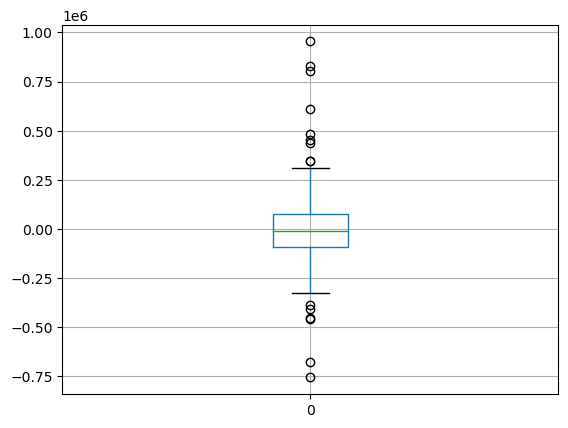

In [707]:
pd.DataFrame(result_98105.resid).boxplot()

In [708]:
outlier = house_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePrice :', outlier[outcome])
print(outlier[predictors])

AdjSalePrice : 119748.0
SqFtTotLiving    2900
SqFtLot          7276
Bathrooms         3.0
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


<b><h4>Influential Values</h4></b>

A value whose absence would significantly change the regression equation is termed an influential observation. In regression, such a value need not be associated with a large residual. Such a value is said to hve high leverage on the regression. A common measure of leverage is the hat-value; values above 2(P + 1)/n indicate a high-leverage data value.
Another metric is Cook's distance, which defines influence as a combination of levrage and residual size. A rule of thumb is that an observation has high influence if Cook's distance exceeds 4/(n-P-1).

An influence plot or bubble plot combines standardized residuals, the hat-value and Cook's distance in a single plot. The hat values are plotted on the x-asix, the residuals are plotted on the y-axis, and the size of the points is related to the value of Cook's distance.

Text(0, 0.5, 'studentized residuals')

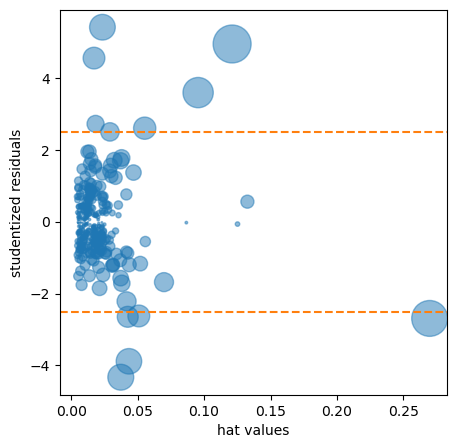

In [709]:
influence = OLSInfluence(result_98105)
fig, ax = plt.subplots(figsize=(5,5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal, 
s=1000*np.sqrt(influence.cooks_distance[0]), alpha=0.5)
ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')

In [710]:
mask = [dist < 0.8 for dist in influence.cooks_distance[0]]
house_infl = house_98105[mask]

ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))
result = ols_infl.fit()

pd.DataFrame({
    'Original' : result_98105.params,
    'Influential removed' : result.params
})

,Original,Influential removed
SqFtTotLiving,209.602346,209.602346
SqFtLot,38.933315,38.933315
Bathrooms,2282.264145,2282.264145
Bedrooms,-26320.268796,-26320.268796
BldgGrade,130000.099737,130000.099737
const,-772549.862447,-772549.862447


The coefficient for Bathrooms changes quite dramatically after influential data points are removed. The coefficient for Bathrooms becomes negative, which is unintuitive. Location has not been taken into account (confounding variable), and the zip code 98105 contains areas of disparate types of homes . For purposes of fitting a regression that reliably predicts future data, identifying influential observations is useful only in smaller data sets. For regressions involving many records, it is unlikely that any one observation will carry sufficient weight to cause extreme influence on the fitted equation (although the regression may still have big outliers). For purposes of anomaly detection, though, identifying influential observations can be very useful.

<b><h4>Heteroskedasticity, Non-Normality, and Correlated Errors</h4></b>

Statisticians pay considerable attention to the distribution of the residuals. It turns out that ordinary least squares, are unbiased, and in some cases are the "optimal" estimator, under a wide range of distributional assumptions. This means that in most problems, data scientists do not need to be too concerned with the distribution of the residuals.

The distribution of residuals is relevant mainly for the validity of formal statistical inference (hypothesis tests and p-values), which is of minimal importance to data scientists concerned mainly with predictive accuracy. Normally distributed errors are a sign that the model is complete. errors that are not normally distributed indicate the model may be missing something. For formal inference to be fully valid, the residuals are assumed to be normally distributed, have the same variance, and be independent. One area where this may be of concertn to data scientists is the standard calculation of confidence intervals for predicted values, which are based upon the assumptions about the residuals.

Heteroskedasticity is the lack of constant residual variance across the range of the predicted values. In other words, the errors are greater for some portions of the range than for others. Visualizing the data is a convenient way to analyze the residuals. In Python, the seaborn package has the regplot function to create such visualizations.

Text(0, 0.5, 'abs(result)')

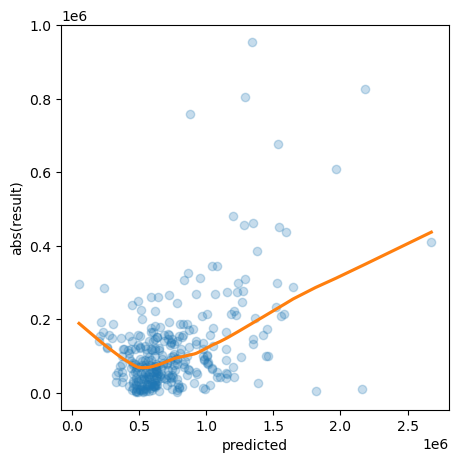

In [711]:
fig, ax = plt.subplots(figsize=(5,5))
sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid), 
    scatter_kws={'alpha':0.25}, line_kws={'color':'C1'}, lowess=True, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('abs(result)')

Evidently the variance of the residuals tend to increase for higher-valued homes but is also large for lower-valued homes. This plot indicates that model lm_98105 has heteroskedastic errors. The plot above was made using the seaborn function regplot(), which plots data and a linear regression fit. The x is the fitted values resulting from lm_98105, the y is the absolute of the residuals from the same model, scatter plot's (data) properties are provided to the scatter_kws argument, the line plot's (regression) properties are provided to the line_kws keyword argument, and the regression line is provided by fitting the x values using lowest weighted regression via statsmodels so we set the lowess argument parameter to True.

Heteroskedasticity indicates that prediction errors differ for different ranges of the predicted value, and may suggest an incomplete model. For example,the heteroskedasticity in lm_98105 may indicate that the regression has left something unaccounted for in high and low-range homes.

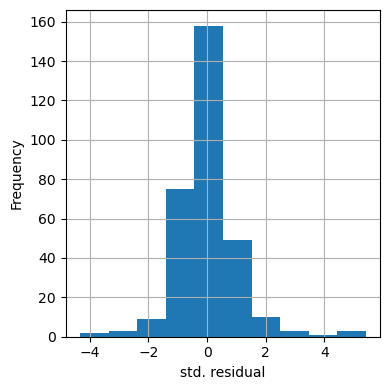

In [712]:
fig, ax = plt.subplots(figsize=(4,4))
pd.Series(influence.resid_studentized_internal).hist(ax=ax)
ax.set_xlabel('std. residual')
ax.set_ylabel('Frequency')
plt.tight_layout()

The plot above is a histogram of the standardized residuals for the lm_98105 regression. The distribution has decidedly longer tails than the normal distribution and exhibits mild skewness toward larger residuals.

Statisticiand may also check the assumption that the errors are independent. This is particularly true for data that is collected over time or space. The <em>Durbin-Watson</em> statistic can be used to detect if thee is significant autocorrelation in a regression involving time series data. If the errors from a regression model are correlated, then this information can be useful in making short-term forecasts and should be built into the model.

<b><h4>Scatter Smoothers</h4></b>

Regression is about modeling the relationship between the response and predictor variables. In evaluating a regression model, it is useful to use a scatterplot smoother to visually highlight relationships between two variables. In the residual plot above, a smooth of this relationship between the absolute residuals and the predicted value shows that the variance of the residuals depends on the value of the residual. In this case, the <em>loess</em> function was used; <em>loess</em> works by repeatedly fitting a series of local regressions to contiguous subsets to come up with a smooth. While <em>loess</em> is probably the most commonly used smoother, other scatterplot smoothers are available. In Python, we can find additional smoothers in <em>scipy (wiener or sav)</em> and statsmodels (kernel_regression). For the purposes of evaluating a regression model, there is typically no need to worry about the details of these scatterplot smooths.

<b><h4>Partial Residual Plots and Nonlinearity</h4></b>

Partial residual plots are a way to visualize how well the estimated fit explains the relationship between a predictor and the outcome. The basic idea of a partial residual plot is to isolate the relationship between a predictor variable and the response, taking into account all of the other predictor variables. A partial residual might be thought of as a synthetic outcome value, combining the prediction based on a single predictor with the actual residual from the full regression equatioin. A partial residual for the predictor $X_i$ is the ordinary residual plus the regression term associated with $X_i$.

$Partial\;residual$ = $Residual\;+\; \hat b_iX_i$

where $\hat b_i$ is the estimated regression coefficient. The partial residual plot displays the $X_i$ predictor on thhe x-axis and the partial residual on the y-axis. The statsmodels package has the method <em>sm.graphics.plot_ccpr</em> that creates a partial residual plot for a specified column. We use <em>sm.graphics.plot_ccpr_grid()</em> to create partial residual plots for all columns.

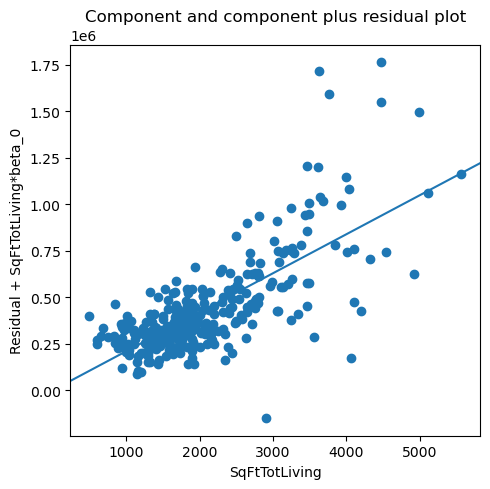

In [713]:
fig, ax = plt.subplots(figsize=(5,5))
sm.graphics.plot_ccpr(result_98105, 'SqFtTotLiving', ax=ax) # plot one predictor
plt.tight_layout()

The partial residual plot above is an estimate of the contribution that SqFtTotLiving adds to the sales price. The relationship between SqFtTotLiving and sales price is evidently nonlinear (scatter pattern). The regression line underestimates the sales price for homes between 2,000 and 3,000 square feet. There are too few data points above 4,000 square feet to draw conclusions for those homes.

The nonlinearity makes sense in this case: adding 500 feet in a small home makes a much bigger difference than adding 500 feet in a large home. This suggests that instead of a simple linear term for SqFtTotLiving, a nonlinear term should be considered.

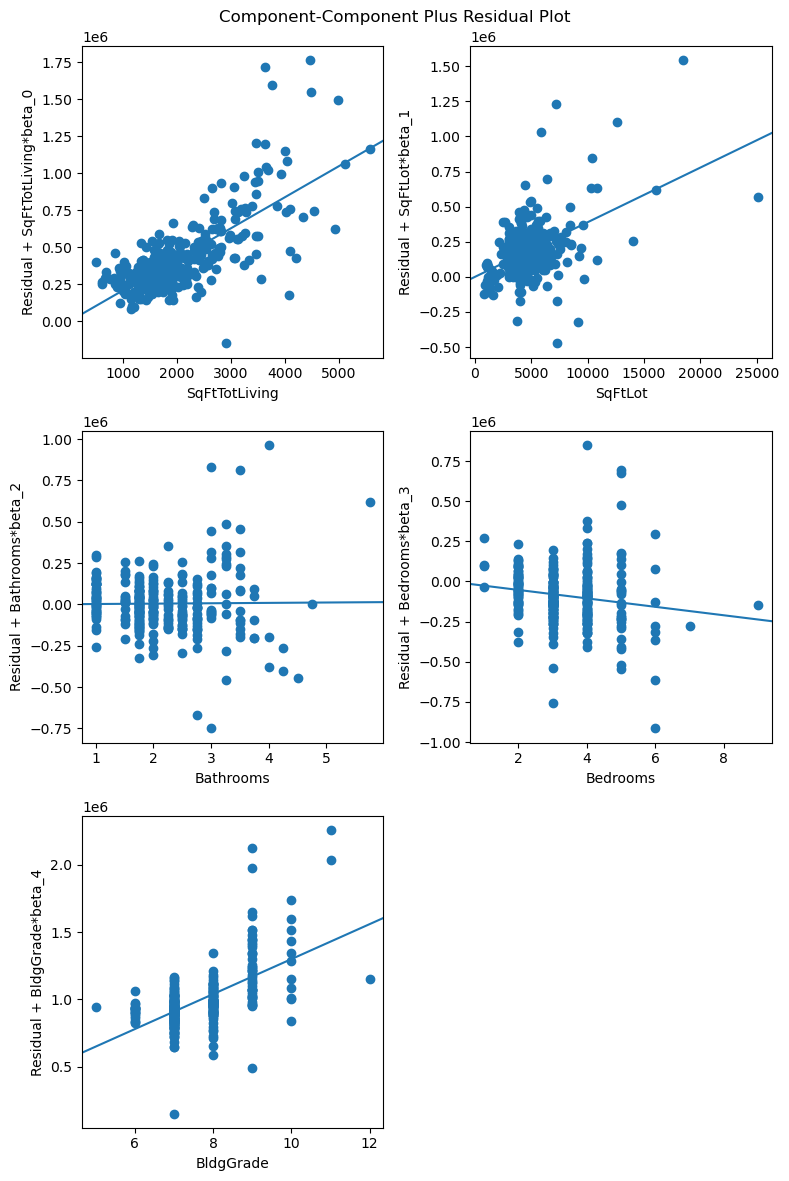

In [714]:
fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig) # plot all predictors, result_98105 is an sm OLS object

<b><h3>Polynomial and Spline Regression</h3></b>

The relationship between the response and a predictor variable isn't necessarily linear. The response to the dose of a drug is often nonlinear: doubling the dose generally doesnt lead to a doubled response. The demand for a product isnt a linear function of marketing dollars spent;, at some point, demand is likely to be saturated. There are many ways that regression can be extended to capture these nonlinear effects.

When statisticians talk about nonlinear regression, they are referring to models that can't be fit using least squares. What kind of models are nonlinear? Essentially all models where the response cannot be expressed as a linear combination of the predictors or some transform of the predictors. Nonlinear regression models are harder and computationally more intensive to fit, since they require numerical optimization. For this reason, it is generally preferred to use a linear model if possible.

<b><h4>Polynomial</h4></b>

<em>Polynomial regression</em> involves including polynomial terms in a regression equation. For example, a quadratic regression between the response $Y$ and the predictor $X$ would take the form:

$Y$ = $b_0\;+\;b_1X\;+\;b_2X^2\;+\;e$

In statsmodels, we use the formula to add the squared term to the model definition using I(SqFtTotLiving**2). When we do this, there are now two coefficients associated with SqFtTotLiving: one for the linear term and one for the quadratic term. 

In [716]:
model_poly = smf.ols(
    formula='AdjSalePrice ~ SqFtTotLiving +' +
    '+ I(SqFtTotLiving**2) + ' +
    'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105
)

result_poly = model_poly.fit()
result_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Tue, 19 Sep 2023   Prob (F-statistic):          9.95e-106
Time:                        13:00:17   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -6.159e+05   1.03e+05     -5.953      0.000   -8.19e+05   -4.12e+05
SqFtTotLiving             7.4521     55.418      0.134      0.893    -101.597     116.501
I(SqFtTotLiving ** 2)     0.0388      0.010      4.040      0.000       0.020       0.058
SqFtLot                  32.5594      5.436      5.990      0.000      21.863      43.256
Bathrooms             -1435.1231   1.95e+04     -0.074      0.941   -3.99e+04     3.7e+04
Bedrooms              -9191.9441   1.33e+04     -0.693      0.489   -3.53e+04    1.69e+04
BldgGrade              1.357e+05   1.49e+04      9.087      0.000    1.06e+05    1.65e+05
==============================================================================
Omnibus:                       75.161   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              637.978
Skew:                           0.699   Prob(JB):                    2.92e-139
Kurtosis:                       9.853   Cond. No.                     7.37e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.37e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

0.038791281682365425


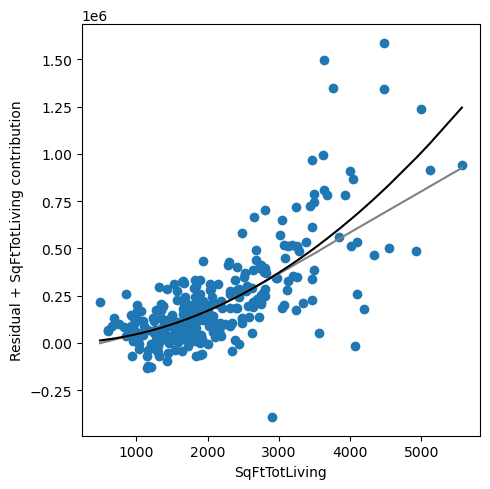

In [719]:
def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()

    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0  # all cols except SqFtTotLiving are 0

    feature_prediction =  model.predict(copy_df)   # prediction only uses SqFtTotLiving, linear and polynomial 

    results = pd.DataFrame({
        'feature' :  df[feature],   # feature column for polynomial modeling and residual plot
        'residual' : df[outcome] - y_pred,  # residual with full model, Residual
        'ypartial' : feature_prediction - model.params[0], # partial model pred minus intercept term = biXi
    })

    results = results.sort_values(by=['feature'])  # sort rows in ascending order of feature column
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3) # smooth biXi using lowess, 
    
    ax.scatter(results.feature, results.ypartial + results.residual) # x = sorted col, y = Residual+biXi, partial
    ax.plot(smoothed[:,0], smoothed[:,1], color ='gray' )       # plot biXi smoothed line (loess) column contribution
    ax.plot(results.feature, results.ypartial, color='black')   # line plot biXi, contribution to model by feature
    ax.set_xlabel(feature) 
    ax.set_ylabel(f"Residual + {feature} contribution")
    return ax

fig, ax = plt.subplots(figsize=(5,5))
partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
print(result_poly.params[2])

The statsmodels function sm.graphics.plot_ccpr() only works for generating residual plots for linear models, but after fitting a polynomial model on SqFtTotLiving column, we use the function above to produce our own residual plot.

The partial residual plot indicates some curvature in the regression equation associated with SqFtTotLiving. The fitted line more closely matches the smooth of the partial residuals as compared to a linear fit.

In [724]:
result_poly.params

Intercept               -615850.841791
SqFtTotLiving                 7.452134
I(SqFtTotLiving ** 2)         0.038791
SqFtLot                      32.559355
Bathrooms                 -1435.123106
Bedrooms                  -9191.944128
BldgGrade                135717.060127
dtype: float64

<b><h4>Splines</h4></b>

Polynomial regression captures only a certain amount of curvature in a nonlinear relationship. Adding in higher-order terms, such as cubic quartic polynomial, often leads to undesirable "wiggliness" in the regression equation. An alternative, and often superior, approach to modeling nonlinear relationships is to use splines. Splines provide a way to smoothly interpolate between fixed points. Splines were originally used by draftsmen to draw a smooth curve, particularly in ship and aircraft building. The splines were created by bending a thin piece of wood using weights, referred to as "ducks".

The technical definition of a spline is a series of piecewise continuous polynomials. The polynomial pieces are smoothly connected at a series of fixed points in a predictor variable, referred to as knots. Formulation of splines is much more complicated than polynomial regression; statistical software usually handles the details of fitting a spline. 
The statsmodels formula interface supports the use of splines. Here, we specify the b-spline using df, the degrees of freedom as bs(SqFtTotLiving, df=6, degree=3); this will create a df - degree = 6 - 3 = 3 internal knots with positions.

In [731]:
formula = ('AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' +
            'SqFtLot + Bathrooms + Bedrooms + BldgGrade')

model_spline = smf.ols(formula=formula, data=house_98105)
results_spline = model_spline.fit()
results_spline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Tue, 19 Sep 2023   Prob (F-statistic):          7.10e-104
Time:                        14:14:21   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                            -4.142e+05   1.43e+05     -2.899      0.004   -6.95e+05   -1.33e+05
bs(SqFtTotLiving, df=6, degree=3)[0] -1.995e+05   1.86e+05     -1.076      0.283   -5.65e+05    1.66e+05
bs(SqFtTotLiving, df=6, degree=3)[1] -1.206e+05   1.23e+05     -0.983      0.326   -3.62e+05    1.21e+05
bs(SqFtTotLiving, df=6, degree=3)[2] -7.164e+04   1.36e+05     -0.525      0.600    -3.4e+05    1.97e+05
bs(SqFtTotLiving, df=6, degree=3)[3]  1.957e+05   1.62e+05      1.212      0.227   -1.22e+05    5.14e+05
bs(SqFtTotLiving, df=6, degree=3)[4]  8.452e+05   2.18e+05      3.878      0.000    4.16e+05    1.27e+06
bs(SqFtTotLiving, df=6, degree=3)[5]  6.955e+05   2.14e+05      3.255      0.001    2.75e+05    1.12e+06
SqFtLot                                 33.3258      5.454      6.110      0.000      22.592      44.059
Bathrooms                            -4778.2080   1.94e+04     -0.246      0.806    -4.3e+04    3.34e+04
Bedrooms                             -5778.7045   1.32e+04     -0.437      0.663   -3.18e+04    2.03e+04
BldgGrade                             1.345e+05   1.52e+04      8.842      0.000    1.05e+05    1.64e+05
==============================================================================
Omnibus:                       58.816   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              622.021
Skew:                           0.330   Prob(JB):                    8.51e-136
Kurtosis:                       9.874   Cond. No.                     1.97e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

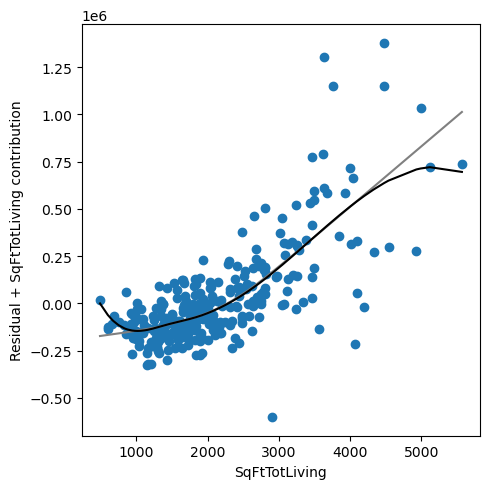

In [733]:
fig, ax = plt.subplots(figsize=(5,5))
partialResidualPlot(results_spline, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax=ax)
plt.tight_layout()

In contrast to a linear term, for which the coefficient has a direct meaning, the coefficients for a spline term are not interpretable. Instead, it is more useful to use the visual display to reveal the nature of the spline fit. 

For our example data, the spline model more closely matches the smooth than the polynomial model, demonstrating the greater flexibility of splines. In this case, the line more closely fits the data. Does this mean the spline regression is a better model? Not necessarily: it doesnt make economic sense that very small homes (less than 1000 square ft) would have a higher value than slightly larger homes. This is possibly an artifact of a confounding variable.

<b><h3>Generative Additive Models</h3></b>

Suppose you suspect a nonlinear relationship between the response and a predictor variable, either by a prior knowledge or the examining the regression diagnostics. Polynomial terms may not be flexible enough to capture the relationship, and spline terms require specifying the knots. Generalized additive modesls, or GAM, are a flexible modeling technique that can be used to automatically fit a spline regression. Generative models try to find the 'best' knots for a spline term.

In Python, we can use the pyGAM package. It provides methods for regression and classification. Here, we use LinearGAM to create a regression model. We can also use statsmodels for GAM modeling.

In [734]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

X = house_98105[predictors].values
y = house_98105[outcome]

gam = LinearGAM(s(0, n_splines=12) + l(1) + l(2) + l(3) + l(4))
gam.gridsearch(X,y)
gam.summary()

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:  00:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.6772
Link Function:                     IdentityLink Log Likelihood:                                 -7833.1159
Number of Samples:                          313 AIC:                                            15683.5863
                                                AICc:                                             15684.14
                                                GCV:                                      30838885095.1686
                                                Scale:                                    29480381715.8302
                                                Pseudo R-Squared:                                   0.8117
Feature Function                  Lam

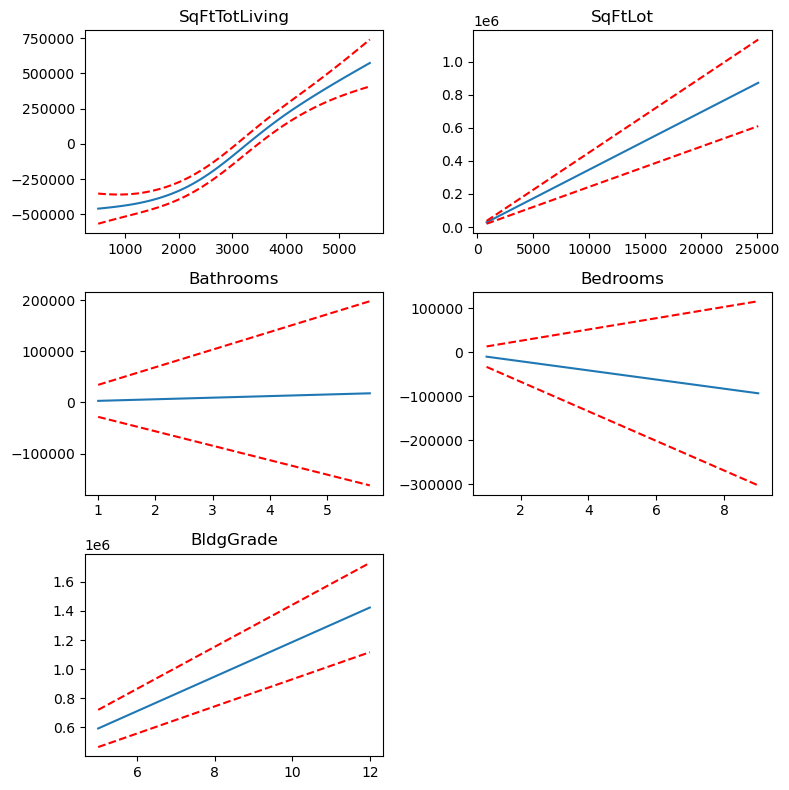

In [736]:
fig, axes = plt.subplots(figsize=(8,8), nrows=3, ncols=2)

titles = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
for i, title in enumerate(titles):
    ax = axes[i//2, i%2]
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:,i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:,i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i])

axes[2][1].set_visible(False)

plt.tight_layout()


In [739]:
from statsmodels.gam.api import GLMGam, BSplines

x_spline = house_98105[predictors] 
bs = BSplines(x_spline, df = [10] + [3] * 4, degree=[3] + [2] * 4)
#penalization weight
alpha = np.array([0]*5)

formula = ('AdjSalePrice ~ SqFtTotLiving +' +
            'SqFtLot + Bathrooms + Bedrooms + BldgGrade')

gam_sm = GLMGam.from_formula(formula, data=house_98105, smoother=bs, alpha=alpha)
res_sm = gam_sm.fit()
res_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           AdjSalePrice   No. Observations:                  313
Model:                         GLMGam   Df Residuals:                   295.00
Model Family:                Gaussian   Df Model:                        17.00
Link Function:               identity   Scale:                      2.7471e+10
Method:                         PIRLS   Log-Likelihood:                -4196.6
Date:                Tue, 19 Sep 2023   Deviance:                   8.1039e+12
Time:                        15:13:13   Pearson chi2:                 8.10e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9901
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3.481e+05   1.18e+05     -2.962      0.003   -5.79e+05   -1.18e+05
SqFtTotLiving      192.1472     50.663      3.793      0.000      92.849     291.446
SqFtLot              6.9002      7.654      0.902      0.367      -8.101      21.902
Bathrooms        -7836.2808   2.12e+04     -0.370      0.712   -4.94e+04    3.37e+04
Bedrooms         -8297.4370   1.26e+04     -0.660      0.509   -3.29e+04    1.63e+04
BldgGrade         1.014e+05    1.4e+04      7.249      0.000     7.4e+04    1.29e+05
SqFtTotLiving_s0  1.465e+05   2.34e+05      0.626      0.531   -3.12e+05    6.05e+05
SqFtTotLiving_s1 -6.174e+04   1.33e+05     -0.464      0.642   -3.22e+05    1.99e+05
SqFtTotLiving_s2 -3.186e+04   1.26e+05     -0.253      0.800   -2.78e+05    2.15e+05
SqFtTotLiving_s3 -5.403e+04   1.01e+05     -0.535      0.593   -2.52e+05    1.44e+05
SqFtTotLiving_s4 -1.182e+05   1.01e+05     -1.167      0.243   -3.17e+05    8.03e+04
SqFtTotLiving_s5 -1.295e+05   8.23e+04     -1.574      0.115   -2.91e+05    3.17e+04
SqFtTotLiving_s6 -3.014e+04   1.27e+05     -0.237      0.813    -2.8e+05     2.2e+05
SqFtTotLiving_s7  1.262e+05    1.8e+05      0.702      0.483   -2.26e+05    4.79e+05
SqFtTotLiving_s8  5.325e+04   1.38e+05      0.386      0.700   -2.17e+05    3.24e+05
SqFtLot_s0        5.775e+05   1.58e+05      3.651      0.000    2.68e+05    8.88e+05
SqFtLot_s1       -2.771e+05   7.86e+04     -3.526      0.000   -4.31e+05   -1.23e+05
Bathrooms_s0      3.723e+04   1.06e+05      0.351      0.726   -1.71e+05    2.45e+05
Bathrooms_s1      5.303e+04   5.94e+04      0.892      0.372   -6.35e+04     1.7e+05
Bedrooms_s0       2.298e+05   1.31e+05      1.751      0.080   -2.74e+04    4.87e+05
Bedrooms_s1      -7.241e+04   6.81e+04     -1.063      0.288   -2.06e+05    6.11e+04
BldgGrade_s0     -7.953e+05   2.03e+05     -3.917      0.000   -1.19e+06   -3.97e+05
BldgGrade_s1      6.608e+05   1.14e+05      5.818      0.000    4.38e+05    8.83e+05
====================================================================================
"""

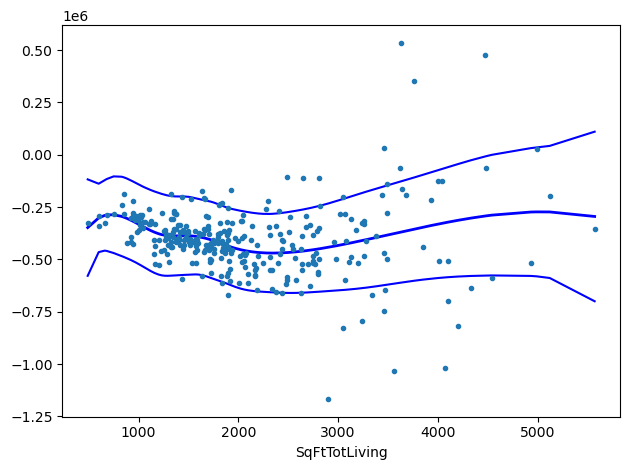

In [744]:
res_sm.plot_partial(0, cpr=True)
plt.tight_layout()

<b><h3>Key Ideas</h3></b>

- Outliers in a regression are records with a large residual.
- Multicollinearity can cause numerical instability in fitting the regression equation.
- A confounding variable is an important predictor that is omitted from a model and can lead to a regression equation with spurious relationships.
- An interaction term between two variables is needed if the effect of one variable depends on the level or magnitude of the other.
- Polynomial regression can fit nonlinear relationships between predictors and the outcome variable.
- Splines are series of polynomial segments strung together, joining at knots.
- We can automate the process of specifying the knots in splines using generalized additive models (GAM).